In [ ]:
import matplotlib.pyplot  as plt
import numpy as np
from scipy.stats import beta
from matplotlib.figure import Figure
import pymc3 as pm
import arviz as az
from scipy.stats import beta
from scipy.stats import bernoulli
import warnings;
import pandas as pd
import math
import graphviz
import seaborn as sns

In [ ]:
data = pd.read_csv("/content/champions_league2.csv")
data.head()
data.describe()

,Home_coeff,Away_coeff,goals_scored,Home,Away,Final
count,5972.000000,5972.000000,5972.000000,5972.000000,5972.000000,5972.000000
mean,45.436933,45.436933,1.323677,0.497656,0.497656,0.004689
std,40.288966,40.288966,1.311437,0.500036,0.500036,0.068318
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.260000,11.260000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,33.000000,1.000000,0.000000,0.000000,0.000000
75%,78.000000,78.000000,2.000000,1.000000,1.000000,0.000000
max,136.000000,136.000000,10.000000,1.000000,1.000000,1.000000


In [ ]:
with pm.Model() as mdl_uefa:
    # define priors, strongly informative Uniform
    b1 = pm.Uniform("Home_coeff",lower = -2, upper= 2)
    b2 = pm.Uniform("Away_coeff",lower = -2,upper= 2)
    b3 = pm.Uniform("Home",lower= -2,upper= 2)
    b4 = pm.Uniform("Away",lower= -2,upper= 2)
    b5 = pm.Uniform("Final",lower=-2,upper= 2)
    # define linear model and exp link function
    theta = pm.math.exp(b1*data["Home_coeff"] + b2*data['Away_coeff'] + b3*data['Home'] + b4*data['Away'] +b5*data['Final'])
    ## Define Poisson likelihood
    y = pm.Poisson("goals_scored", mu=theta, observed=data["goals_scored"].values)

with mdl_uefa:
    inf_uefa = pm.sample(20000, cores=1, return_inferencedata=True,init="map")

map_estimate = pm.find_MAP(model=mdl_uefa)
map_estimate    

Auto-assigning NUTS sampler...
Initializing NUTS using map...


Sequential sampling (2 chains in 1 job)
NUTS: [Final, Away, Home, Away_coeff, Home_coeff]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 1995 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


{'Away': array(0.0372918),
 'Away_coeff': array(-0.00607367),
 'Away_coeff_interval__': array(-0.80618541),
 'Away_interval__': array(-0.6820345),
 'Final': array(0.3353815),
 'Final_interval__': array(0.08851148),
 'Home': array(0.41044238),
 'Home_coeff': array(0.00601298),
 'Home_coeff_interval__': array(-0.7710218),
 'Home_interval__': array(0.27788034)}

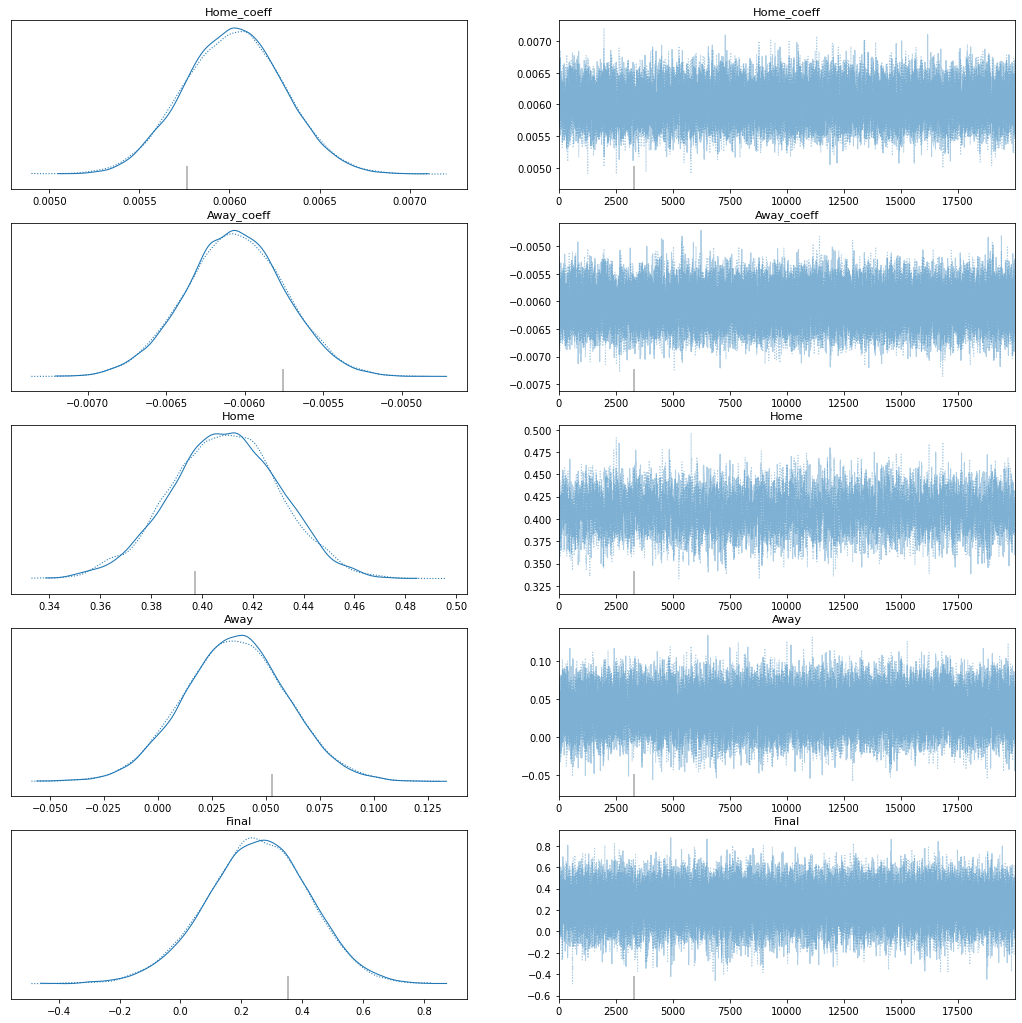

In [ ]:
with mdl_uefa:
    az.plot_trace(inf_uefa,figsize=[18,18]);

In [ ]:
with mdl_uefa:
    display(az.summary(inf_uefa, round_to=4))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Home_coeff,0.0060,0.0003,0.0055,0.0065,0.0000,0.0000,11362.9219,17469.6328,1.0002
Away_coeff,-0.0061,0.0003,-0.0067,-0.0055,0.0000,0.0000,17157.5276,25948.3728,1.0001
Home,0.4091,0.0215,0.3691,0.4503,0.0004,0.0003,3529.0126,4383.9089,1.0004
Away,0.0359,0.0239,-0.0083,0.0814,0.0002,0.0002,12303.8914,21070.2934,1.0001
Final,0.2525,0.1698,-0.0748,0.5613,0.0011,0.0008,24235.8401,17914.4676,1.0001


In [ ]:
Home_coeff_samples=list(inf_uefa.posterior.Home_coeff.values[1][5000:10000])
Away_coeff_samples=list(inf_uefa.posterior.Away_coeff.values[1][5000:10000])
Home_samples=list(inf_uefa.posterior.Home.values[1][5000:10000])
Away_samples=list(inf_uefa.posterior.Away.values[1][5000:10000])
Final_samples=list(inf_uefa.posterior.Final.values[1][5000:10000])

In [ ]:
df = pd.DataFrame(list(zip(Home_coeff_samples,Away_coeff_samples,Home_samples,Away_samples,Final_samples)),columns=["Home_coeff_samples","Away_coeff_samples","Home_samples","Away_samples","Final_samples"])
df

,Home_coeff_samples,Away_coeff_samples,Home_samples,Away_samples,Final_samples
0,0.006169,-0.005544,0.371566,0.042593,0.149629
1,0.006263,-0.005877,0.366344,0.014449,0.508096
2,0.006379,-0.005729,0.365241,0.015297,0.351481
3,0.006725,-0.006083,0.364996,-0.002443,0.218153
4,0.006399,-0.006004,0.381514,0.018717,0.535673
...,...,...,...,...,...
4995,0.005868,-0.005897,0.422379,0.038017,0.331811
4996,0.005571,-0.005942,0.419915,0.039018,0.194433
4997,0.005461,-0.006080,0.420804,0.063603,0.283227
4998,0.005335,-0.005439,0.420843,0.037909,0.330913


In [ ]:
df.to_csv('coefficients-new.csv')